In [1]:
import os
import sys
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import models

from PIL import Image
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import random
def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3Q
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6
    


In [2]:
manual_seed(646)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 1024 # 64

In [4]:
print(device)

cuda


In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True, download=False, transform=train_transforms)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

val_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False, download=False, transform=train_transforms)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)


In [6]:
EPOCHS = 100
# LR = 1e-4
LR = 1e-4
LATENT_DIM = 2

In [7]:
encoder = models.Encoder(LATENT_DIM)
decoder = models.Decoder(LATENT_DIM)
model = models.VAEMLP(encoder, decoder)
print(model)

VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [8]:
def kl_function(mean, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return KLD
MSE_loss = nn.MSELoss(reduction='sum')
KL_loss = kl_function


en_params = ["encoder"]

optimizer_Grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in en_params)], #   Mse
            "lr": LR,
            "weight_decay": 0.0
    }   ,
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in en_params)],
            "lr": LR,
            "weight_decay": 0.0
    }   

]
# en_optimizer = torch.optim.Adam(model.encoder.parameters(), lr=LR, weight_decay=0.0005)
# de_optimizer = torch.optim.Adam(model.decoder.parameters(), lr=LR, weight_decay=0.0001)
optimizer = torch.optim.Adam(optimizer_Grouped_parameters)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [9]:
model.to(device)
generate_imgs = []
noise = torch.randn(batch_size, LATENT_DIM).to(device)
mse_list = []
kl_list = []
all_list = []

val_mse_list = []
val_kl_list = []
val_all_list = []
for epoch in range(EPOCHS):
    model.train()
    mse_loss = 0
    kl_loss = 0
    all_loss = 0
    for i, (imgs, _ ) in enumerate(train_loader):
        imgs = imgs.to(device)
        imgs = torch.flatten(imgs,1)
        optimizer.zero_grad()
        
        y , mean, log_var = model(imgs)
    
        mse = MSE_loss(y,imgs)
        kl = KL_loss(mean,log_var)
    
        loss = 1 * mse + 1 * kl
        loss.backward()
    
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        mse_loss += mse.item()    
        kl_loss += kl.item()    
        all_loss += loss.item() 
    
    scheduler.step()
    mse_loss /=len(train_dataset.data)    
    kl_loss  /=len(train_dataset.data) 
    all_loss /=len(train_dataset.data) 
    
    print(f"{epoch} EPOCH - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
        
    mse_list.append(mse_loss)
    kl_list.append(kl_loss)
    all_list.append(all_loss)
    if (epoch % 5 == 0):
        with torch.no_grad():
            model.eval()
            val_mse_loss =0
            val_kl_loss =0
            val_all_loss =0
            
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                imgs = torch.flatten(imgs, 1)
        
                y, mean, log_var = model(imgs)
                
                mse = MSE_loss(y, imgs)
                kl = KL_loss(mean,log_var)
                
                loss = mse + kl
                
                val_mse_loss += mse.item()
                val_kl_loss += kl.item()
                val_all_loss += loss.item()
        
            val_mse_loss /=len(val_dataset.data)    
            val_kl_loss  /=len(val_dataset.data) 
            val_all_loss /=len(val_dataset.data)     
            
            print(f"     VAl - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
            
            val_mse_list.append(mse_loss)
            val_kl_list.append(kl_loss)
            val_all_list.append(all_loss)
    
        
            # noise를 통과시킨 decoder의 이미지를를 저장해둡니다
            fake = model.decoder(noise[:12]).detach().cpu().view(12,1,28,28)
            # std = torch.exp(log_var / 2)
            # latent = mean + std * noise
            # fake = model.decoder(latent[:12]).detach().cpu().view(-1, 1, 28, 28)
            generate_imgs.append(vutils.make_grid(fake, nrow=4, padding=2,normalize=True))
            plt.figure(figsize=(5,5))
            plt.axis("off")
            plt.title(f"Training Images {epoch}epoch")
            plt.imshow(np.transpose(generate_imgs[-1],(1,2,0)))
            plt.savefig(f'./gen_imgs/{epoch}.png')


0 EPOCH - MSE : 106.31193, KL : 1.85678, ALL : 108.16871
     VAl - MSE : 106.31193, KL : 1.85678, ALL : 108.16871
1 EPOCH - MSE : 49.49390, KL : 4.10886, ALL : 53.60276
2 EPOCH - MSE : 37.76439, KL : 4.77993, ALL : 42.54433
3 EPOCH - MSE : 34.28286, KL : 4.83490, ALL : 39.11776
4 EPOCH - MSE : 32.47962, KL : 4.84319, ALL : 37.32281
5 EPOCH - MSE : 31.32171, KL : 4.87658, ALL : 36.19830
     VAl - MSE : 31.32171, KL : 4.87658, ALL : 36.19830
6 EPOCH - MSE : 30.56565, KL : 4.86336, ALL : 35.42901
7 EPOCH - MSE : 29.96997, KL : 4.84792, ALL : 34.81789
8 EPOCH - MSE : 29.50708, KL : 4.82028, ALL : 34.32736
9 EPOCH - MSE : 29.09635, KL : 4.82488, ALL : 33.92123
10 EPOCH - MSE : 28.78401, KL : 4.82573, ALL : 33.60974
     VAl - MSE : 28.78401, KL : 4.82573, ALL : 33.60974
11 EPOCH - MSE : 28.64698, KL : 4.81505, ALL : 33.46202
12 EPOCH - MSE : 28.48248, KL : 4.80489, ALL : 33.28737
13 EPOCH - MSE : 28.35908, KL : 4.78467, ALL : 33.14375


100


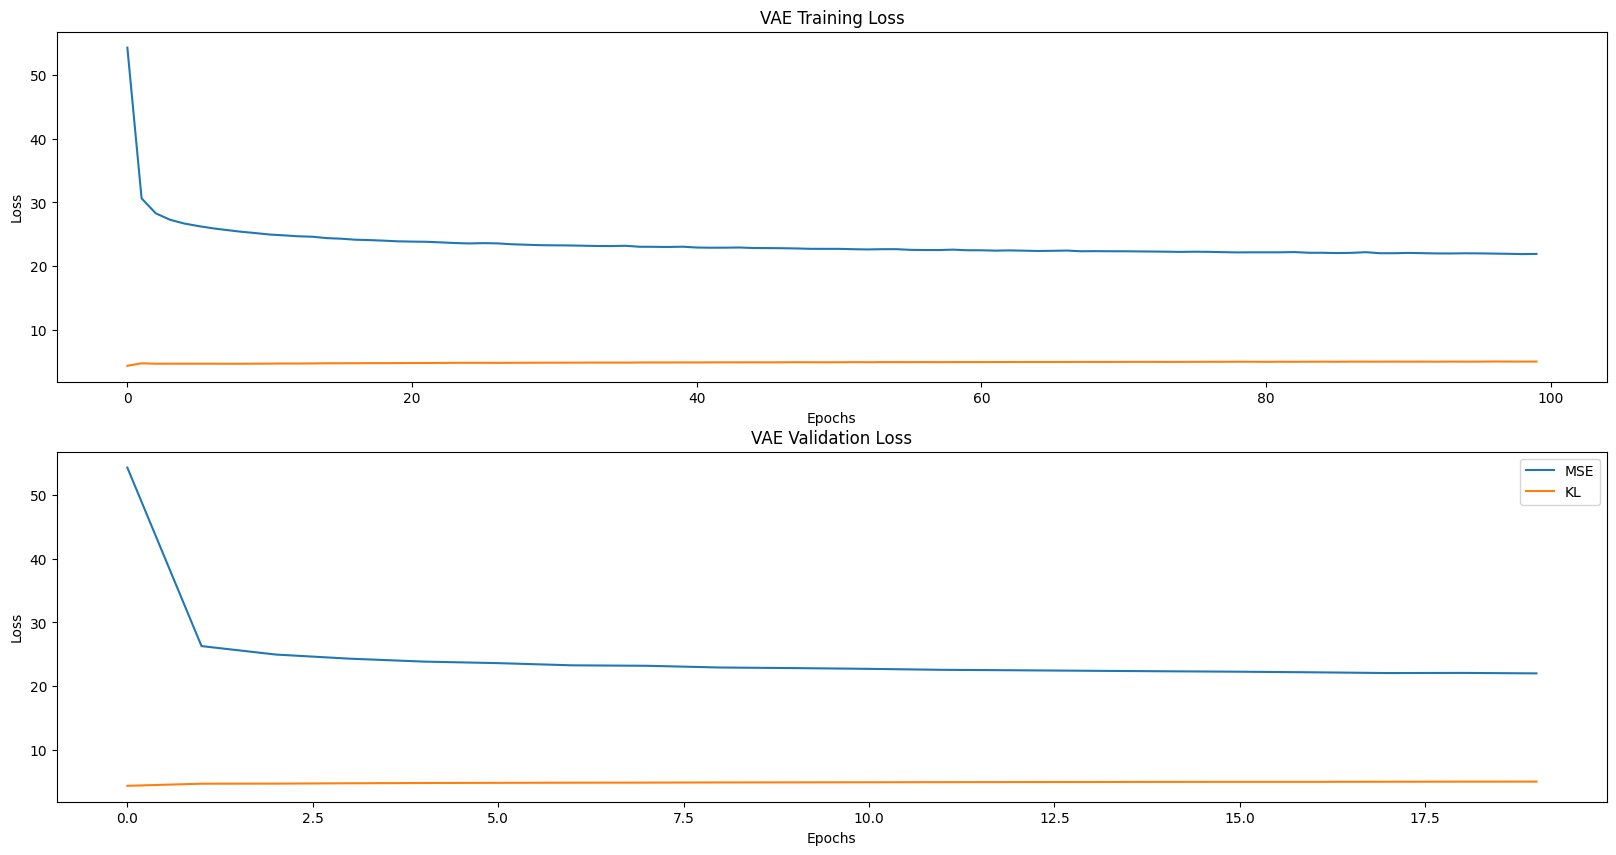

In [ ]:
import matplotlib.pyplot as plt
print(len(mse_list))
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.title(f"VAE Training Loss")
plt.plot(mse_list,label="MSE")
plt.plot(kl_list,label="KL")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(2,1,2)
plt.title(f"VAE Validation Loss")
plt.plot(val_mse_list,label="MSE")
plt.plot(val_kl_list,label="KL")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

torch.Size([3, 92, 122])


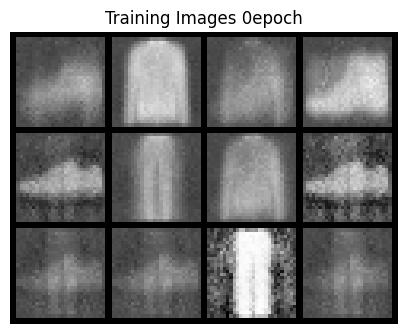

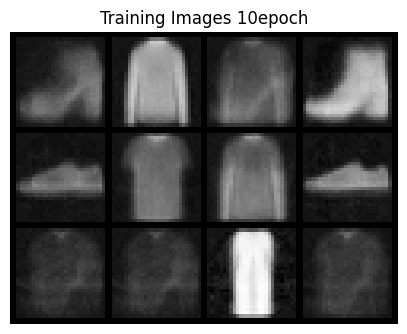

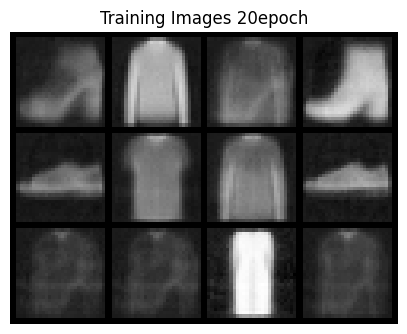

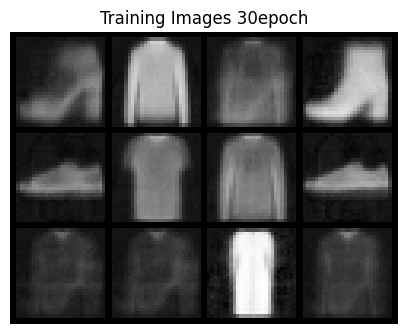

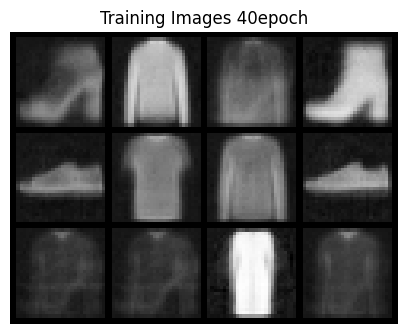

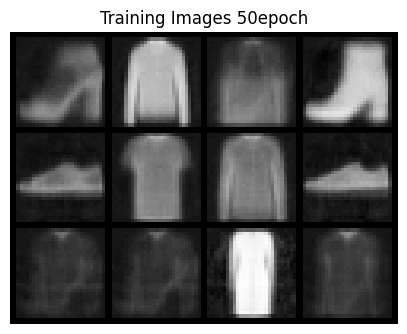

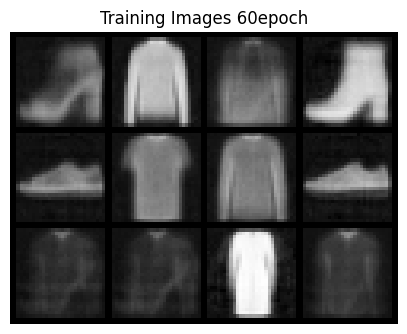

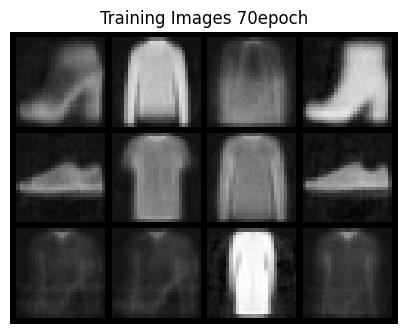

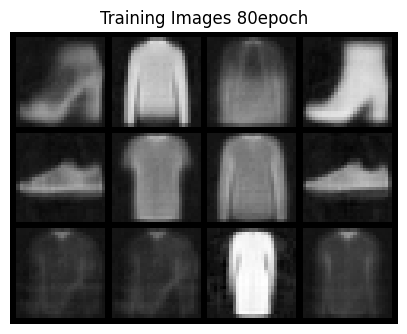

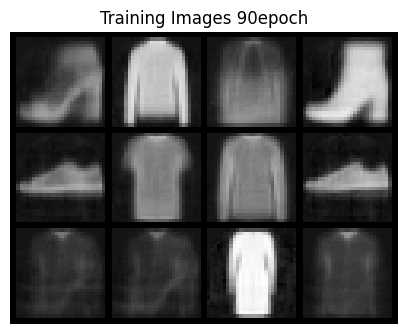

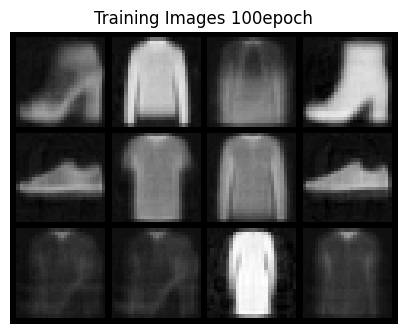

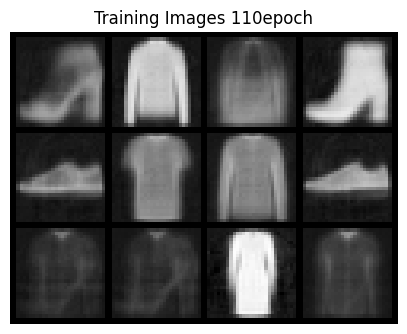

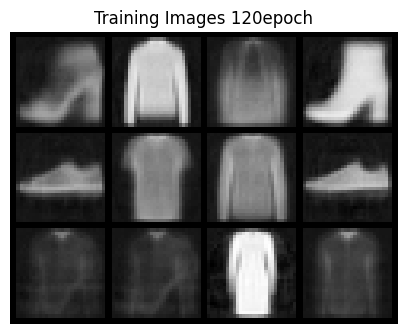

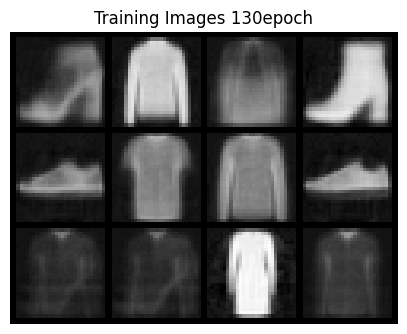

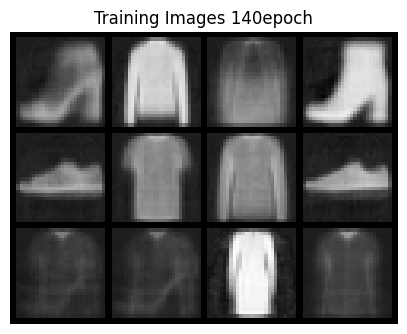

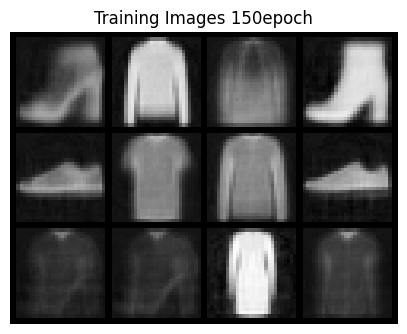

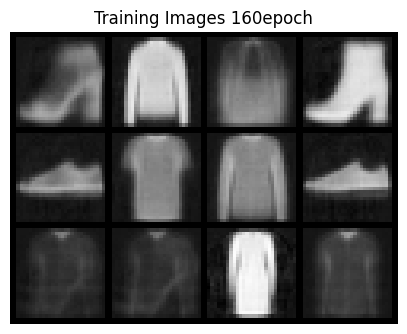

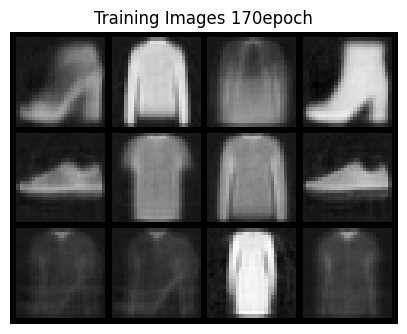

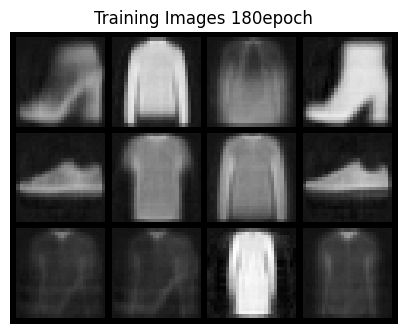

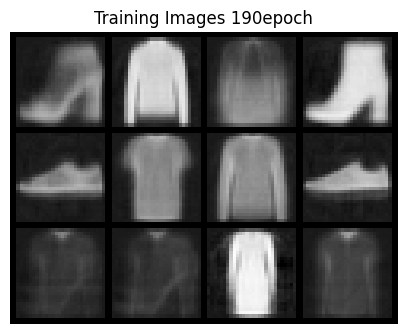

In [ ]:
list_num = len(generate_imgs)
print(generate_imgs[0].shape)
for i in range(0,list_num,1):
    plt.figure(figsize=(5,5))
    target_i = i*10
    plt.axis("off")
    plt.title(f"Training Images {target_i}epoch")
    plt.imshow(np.transpose(generate_imgs[i],(1,2,0)))
